In [1]:
import pandas as pd
import pickle
class Metrics:
    def __init__(self, df):
        self.df = pd.read_pickle(df)
        self.union_speeches = []
        self.rally_speeches = []
        
    def find_avg_word_length(self):
        average_res = []
        rally = self._get_speeches_list_from_df(self.df,1)
        union = self._get_speeches_list_from_df(self.df,0)
        self.rally_speeches.append(rally)
        self.union_speeches.append(union)
        word_count = 0
        total_characters = 0
        for speech_list in [rally, union]:
            for speech in speech_list:
                word_count += len(speech.split())
                total_characters += len(speech) - speech.count(' ')
                
            avg_word_length = total_characters / word_count
            average_res.append(round(avg_word_length,2))
            
            
        return average_res


    def _get_speeches_list_from_df(self, df, attr_val):
        df_speeches = df.loc[df['type'] == attr_val]
        speeches_list = df_speeches['transcript'].tolist()

        return speeches_list

In [2]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

class Compress:
    def save_as_npz(self,df,npz_name=None,tran_data='transcript',label='type'):
        X = []
        y = np.array(df[label])
        sentences = np.array(df[tran_data])
        for sen in sentences:
            X.append(preprocess_text(sen))
        self._train_test_split(np.array(X), np.array(y), npz_filename=npz_name)
        
        

    def _train_test_split(self,X,y,npz_filename=''+'.npz',test_size=0.2, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        np.savez_compressed(npz_filename,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test)
        print("Saved {} as .npz".format(npz_filename))
    

In [4]:
trump_snippits = Metrics("TRUMP_SNIPPETS_DF.pickle")
trump_speeches = Metrics('trump_speeches_df.pickle')
obama_speeches = Metrics('obama_speeches_df.pickle')
obama_snippits = Metrics('OBAMA_SNIPPETS_DF.pickle')


print(trump_snippits.find_avg_word_length(), trump_speeches.find_avg_word_length())
print(obama_snippits.find_avg_word_length(), obama_speeches.find_avg_word_length())

[5.58, 5.67] [4.25, 4.31]
[5.79, 6.04] [4.3, 4.53]


In [5]:
trump_data = pickle.load(open("TRUMP_SNIPPETS_DF.pickle", "rb" ))
obama_data = pickle.load(open("OBAMA_SNIPPETS_DF.pickle", "rb" ))

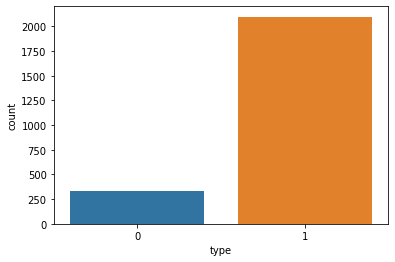

In [6]:
import seaborn as sns
sns.countplot(x='type', data=trump_data)

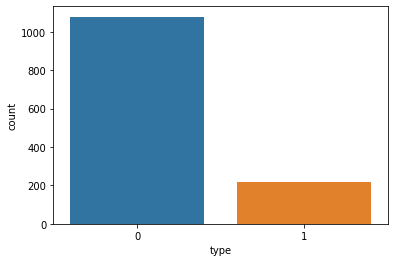

In [7]:
sns.countplot(x='type', data=obama_data)

In [8]:
compress = Compress()
compress.save_as_npz(trump_data, npz_name='TRUMP_SPLIT_DATA')
compress.save_as_npz(obama_data, npz_name='OBAMA_SPLIT_DATA')

(1941,) (1941,) (486,) (486,)
Saved TRUMP_SPLIT_DATA as .npz
(1036,) (1036,) (259,) (259,)
Saved OBAMA_SPLIT_DATA as .npz


In [9]:
class load_file:
    def __init__(self, file):
        self.file = file

    def get_data(self):
        hal = np.load(self.file)
        X_train, y_train, X_test, y_test = [hal[f] for f in hal.files]
        return X_train, y_train, X_test, y_test


df = load_file('dataset_split_transcripts.npz')
X_train, y_train, X_test, y_test = df.get_data()
# Load split data
print(X_train[0])

china many us thats got going thats treat us really badly many others many many others india tariffs us probably higher nation anywhere world tariffs products much india working called prime minister modi said mr prime minister fair weve got change weve got change weve got change talking seriously talking lot places


In [10]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [11]:

vocab_size = 500

X_train = [one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',lower=True, split=' ') for d in X_train]
X_test = [one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',lower=True, split=' ') for d in X_test]

In [12]:
max_length = 25
X_train = pad_sequences(X_train, maxlen=max_length, padding='pre')
X_test = pad_sequences(X_test, maxlen=max_length, padding='pre')

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

model.fit(X_train, y_train, epochs=50, validation_split=.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 8)             4000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 4,201
Trainable params: 4,201
Non-trainable params: 0
_________________________________________________________________
None
Train on 1559 samples, validate on 390 samples
Epoch 1/50


/home/daniel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1559/1559 [==============================] - 1s 482us/step - loss: 0.6605 - acc: 0.7877 - val_loss: 0.6157 - val_acc: 0.8385
Epoch 2/50
1559/1559 [==============================] - 0s 128us/step - loss: 0.5147 - acc: 0.8640 - val_loss: 0.4470 - val_acc: 0.8385
Epoch 3/50
1559/1559 [==============================] - 0s 128us/step - loss: 0.3624 - acc: 0.8640 - val_loss: 0.3770 - val_acc: 0.8385
Epoch 4/50
1559/1559 [==============================] - 0s 125us/step - loss: 0.3103 - acc: 0.8640 - val_loss: 0.3542 - val_acc: 0.8385
Epoch 5/50
1559/1559 [==============================] - 0s 129us/step - loss: 0.2813 - acc: 0.8640 - val_loss: 0.3329 - val_acc: 0.8385
Epoch 6/50
1559/1559 [==============================] - 0s 137us/step - loss: 0.2538 - acc: 0.8672 - val_loss: 0.3123 - val_acc: 0.8436
Epoch 7/50
1559/1559 [==============================] - 0s 125us/step - loss: 0.2277 - acc: 0.8781 - val_loss: 0.2936 - val_acc: 0.8513
Epoch 8/50
1559/1559 [==============================] - 0s 

In [14]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print('Training Accuracy is {}'.format(accuracy*100))

1949/1949 [==============================] - 0s 54us/step
Training Accuracy is 97.48588800430298


In [15]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

488/488 [==============================] - 0s 51us/step
Testing Accuracy is 90.77869057655334 
